In [1]:
import utils.Encryption as cen
import utils.CustomModel as cm
import utils.DataPipeline as dp
import utils.UnsupervisedModels as usm
import tensorflow as tf
from PIL import Image
import json
import cv2 
import numpy as np
import matplotlib.pyplot as plt

2022-09-25 10:10:09.771612: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# root_dir = "F:/pps_paper/dataset"   
root_dir = "/media/blazkowiz47/Work/pps_paper/dataset"  # while on ubuntu 
train_dir = f"{root_dir}/train"
test_dir = f"{root_dir}/test"
validation_dir = f"{root_dir}/validation"
# Change to E / P / PE / N
data_type = 'E'

train_images = f"{root_dir}/train/Data{data_type}"
train_masks = f"{root_dir}/train/GroundTruth_1{data_type}"
test_images = f"{root_dir}/test/Data{data_type}"
test_masks = f"{root_dir}/test/GroundTruth_1{data_type}"
validation_images = f"{root_dir}/validation/Data{data_type}"
validation_masks = f"{root_dir}/validation/GroundTruth_1{data_type}"



Segmentation with Supervised model:

1) CNN

In [ ]:
train = dp.CustomDataset(train_dir,input_dir=f'Data{data_type}', mask_dir=f'GroundTruth_1{data_type}').get_Dataset()
test = dp.CustomDataset(test_dir,input_dir=f'Data{data_type}', mask_dir=f'GroundTruth_1{data_type}').get_Dataset()
validation = dp.CustomDataset(validation_dir,input_dir=f'Data{data_type}', mask_dir=f'GroundTruth_1{data_type}').get_Dataset()

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
model = cm.CustomModel((256,256,3,))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
save_jc = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/',
    monitor='Specificity',
    save_weights_only = True
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=optimizer,
    metrics=
        [cm.DiceIndex(),
        cm.JaccardIndex(),
        cm.Sensitvity(),
        cm.Specificity(),
        cm.Accuracy(),],
    
    )

In [ ]:
history = model.fit(train, validation_data=validation,batch_size=10,epochs=1,workers=2,validation_freq=2,callbacks=[save_jc],)

In [ ]:
history.model.summary()

Let's try plotting the predictions of our model

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

z = None
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    x = tf.keras.utils.array_to_img(display_list[i])
    x = np.array(x)
    # x = cen.unscramble(x,key)
    plt.imshow(x, cmap = None if i == 0 else 'gray')
    plt.axis('off')
  plt.show()

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      z = pred_mask
      display([image[0], mask[0], pred_mask[0]])

In [ ]:
show_predictions(train)

Segmentation with Unsupervised models:

1) K-Means clustering

<Figure size 640x480 with 0 Axes>

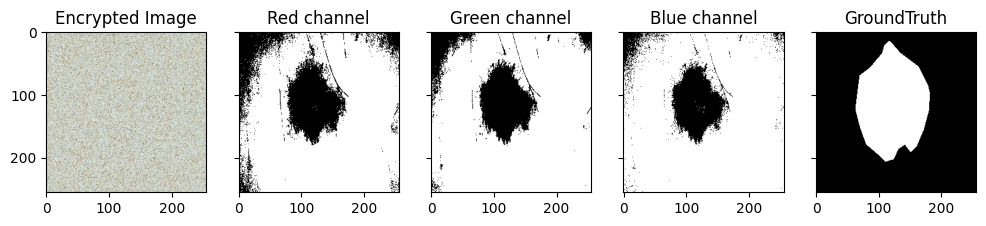

In [4]:
image_name = 'ISIC_0000376' 
img = cv2.imread(f'{train_images}/{image_name}.jpg',1)
groundTruth = cv2.imread(f'{train_masks}/{image_name}_segmentation.png',0)
key = None
with open('key.json','r') as fp:
    key = json.load(fp)

Zb , Zg , Zr = cv2.split(img)
Zb , Zg , Zr = Zb.flatten() , Zg.flatten() , Zr.flatten()  


red = usm.kMeans(Zr,(img.shape[0],img.shape[1]))
red = cen.unscramble(red,key)

green = usm.kMeans(Zg,(img.shape[0],img.shape[1]))
green = cen.unscramble(green,key)


blue = usm.kMeans(Zb,(img.shape[0],img.shape[1]))
blue = cen.unscramble(blue,key)


img = img[...,::-1]
groundTruth = cen.unscramble(groundTruth,key)



plt.figure()

fig , ax = plt.subplots(1,5,sharey=True,figsize = (12,3))

ax[0].imshow(img)
ax[0].set_title('Encrypted Image')
ax[1].imshow(red,cmap='gray')
ax[1].set_title('Red channel')
ax[2].imshow(green,cmap='gray')
ax[2].set_title('Green channel')
ax[3].imshow(blue,cmap='gray')
ax[3].set_title('Blue channel')
ax[4].imshow(groundTruth,cmap='gray')
ax[4].set_title('GroundTruth')

plt.show()


2) DBSCAN

<Figure size 640x480 with 0 Axes>

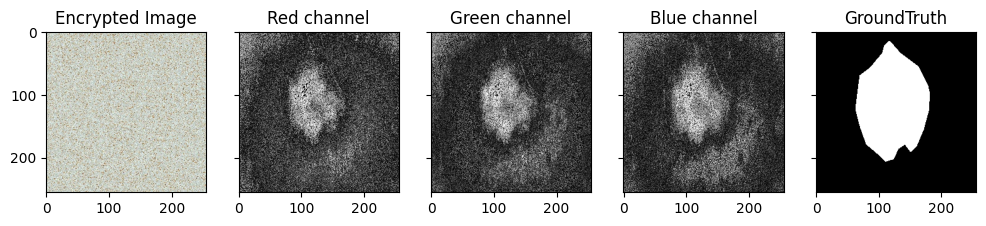

In [4]:
image_name = 'ISIC_0000376' 
img = cv2.imread(f'{train_images}/{image_name}.jpg',1)
groundTruth = cv2.imread(f'{train_masks}/{image_name}_segmentation.png',0)
key = None
with open('key.json','r') as fp:
    key = json.load(fp)

Zb , Zg , Zr = cv2.split(img)
Zb , Zg , Zr = Zb.reshape(-1,1) , Zg.reshape(-1,1) , Zr.reshape(-1,1)  

eps = 1e-7

red = usm.dbscan(Zr,(img.shape[0],img.shape[1]),eps=eps)
red = cen.unscramble(red,key)

green = usm.dbscan(Zg,(img.shape[0],img.shape[1]),eps=eps)
green = cen.unscramble(green,key)


blue = usm.dbscan(Zb,(img.shape[0],img.shape[1]),eps=eps)
blue = cen.unscramble(blue,key)


img = img[...,::-1]
groundTruth = cen.unscramble(groundTruth,key)



plt.figure()

fig , ax = plt.subplots(1,5,sharey=True,figsize = (12,3))

ax[0].imshow(img)
ax[0].set_title('Encrypted Image')
ax[1].imshow(red,cmap='gray')
ax[1].set_title('Red channel')
ax[2].imshow(green,cmap='gray')
ax[2].set_title('Green channel')
ax[3].imshow(blue,cmap='gray')
ax[3].set_title('Blue channel')
ax[4].imshow(groundTruth,cmap='gray')
ax[4].set_title('GroundTruth')

plt.show()


3) Gaussian Mixture

<Figure size 640x480 with 0 Axes>

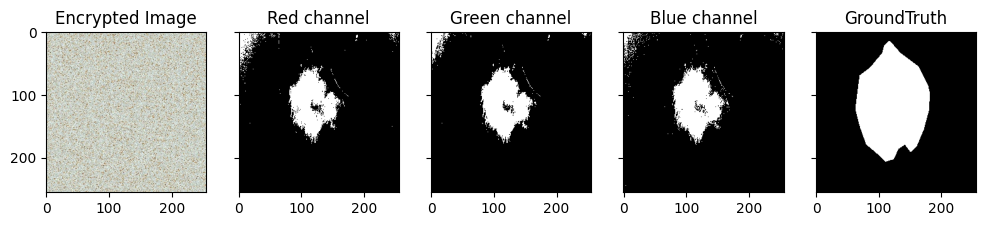

In [3]:
image_name = 'ISIC_0000376' 
img = cv2.imread(f'{train_images}/{image_name}.jpg',1)
groundTruth = cv2.imread(f'{train_masks}/{image_name}_segmentation.png',0)
key = None
with open('key.json','r') as fp:
    key = json.load(fp)

Zb , Zg , Zr = cv2.split(img)
Zb , Zg , Zr = Zb.reshape(-1,1) , Zg.reshape(-1,1) , Zr.reshape(-1,1)  


red = usm.gaussian_mixture(Zr,(img.shape[0],img.shape[1]))
red = cen.unscramble(red,key)

green = usm.gaussian_mixture(Zg,(img.shape[0],img.shape[1]))
green = cen.unscramble(green,key)


blue = usm.gaussian_mixture(Zb,(img.shape[0],img.shape[1]))
blue = cen.unscramble(blue,key)


img = img[...,::-1]
groundTruth = cen.unscramble(groundTruth,key)



plt.figure()

fig , ax = plt.subplots(1,5,sharey=True,figsize = (12,3))

ax[0].imshow(img)
ax[0].set_title('Encrypted Image')
ax[1].imshow(red,cmap='gray')
ax[1].set_title('Red channel')
ax[2].imshow(green,cmap='gray')
ax[2].set_title('Green channel')
ax[3].imshow(blue,cmap='gray')
ax[3].set_title('Blue channel')
ax[4].imshow(groundTruth,cmap='gray')
ax[4].set_title('GroundTruth')

plt.show()

4) BIRCH

/home/blazkowiz47/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/cluster/_birch.py:320: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/home/blazkowiz47/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/cluster/_birch.py:320: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/home/blazkowiz47/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/cluster/_birch.py:320: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/home/blazkowiz47/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/cluster/_birch.py:320: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/home/blazkowiz47/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/cluster/_birch.py:320: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self

<Figure size 640x480 with 0 Axes>

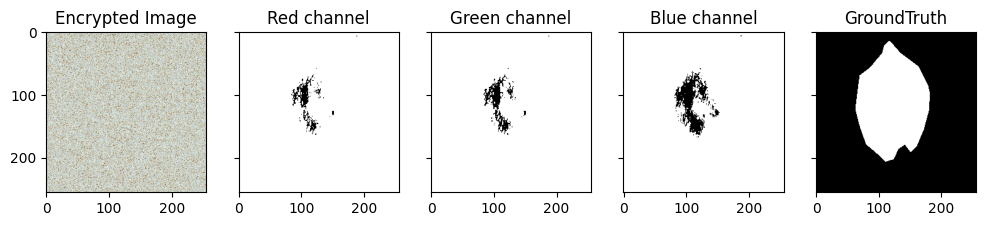

In [3]:
image_name = 'ISIC_0000376' 
img = cv2.imread(f'{train_images}/{image_name}.jpg',1)
groundTruth = cv2.imread(f'{train_masks}/{image_name}_segmentation.png',0)
key = None
with open('key.json','r') as fp:
    key = json.load(fp)

Zb , Zg , Zr = cv2.split(img)
Zb , Zg , Zr = Zb.reshape(-1,1) , Zg.reshape(-1,1) , Zr.reshape(-1,1)  


red = usm.birch(Zr,(img.shape[0],img.shape[1]))
red = cen.unscramble(red,key)

green = usm.birch(Zg,(img.shape[0],img.shape[1]))
green = cen.unscramble(green,key)


blue = usm.birch(Zb,(img.shape[0],img.shape[1]))
blue = cen.unscramble(blue,key)


img = img[...,::-1]
groundTruth = cen.unscramble(groundTruth,key)



plt.figure()

fig , ax = plt.subplots(1,5,sharey=True,figsize = (12,3))

ax[0].imshow(img)
ax[0].set_title('Encrypted Image')
ax[1].imshow(red,cmap='gray')
ax[1].set_title('Red channel')
ax[2].imshow(green,cmap='gray')
ax[2].set_title('Green channel')
ax[3].imshow(blue,cmap='gray')
ax[3].set_title('Blue channel')
ax[4].imshow(groundTruth,cmap='gray')
ax[4].set_title('GroundTruth')

plt.show()